# Titanic solution

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
%matplotlib inline

In [266]:
# importing datasets
train_df = pd.read_csv('./titanic/train.csv')
test_df = pd.read_csv('./titanic/test.csv')
train_df.name = 'Training set'
test_df.name = 'Test set'
train_df['label'] = 'train'
test_df['label'] = 'test'

In [267]:
train_df.info()
print('------------------------------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  label        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------ 

## Data explanation

##### The whole dataset has 11 features:
1. PassengerId - unique number for every passenger
2. Survived - if the passenger survived (1) or not (0)
3. Pclass - passenger class, socio-economic status of the passenger
4. Name - self-explanatory
5. Sex - self-explanatory
6. Age - self-explanatory
7. SibSp - number of siblings/ spouses aboard the Titanic
8. Parch - number of parents/ children aboard the Titanic
9. Ticket - ticket number
10. Fare - passenger fare
11. Cabin - cabin number
12. Embarked - port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [268]:
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,label
656,657,0,3,"Radeff, Mr. Alexander",male,NaN,0,0,349223,7.8958,NaN,S,train
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,train
579,580,1,3,"Jussila, Mr. Eiriik",male,32.0,0,0,STON/O 2. 3101286,7.9250,NaN,S,train
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9000,NaN,S,train
787,788,0,3,"Rice, Master. George Hugh",male,8.0,4,1,382652,29.1250,NaN,Q,train


In [269]:
test_df.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,label
120,1012,2,"Watt, Miss. Bertha J",female,12.0,0,0,C.A. 33595,15.7500,NaN,S,test
107,999,3,"Ryan, Mr. Edward",male,NaN,0,0,383162,7.7500,NaN,Q,test
347,1239,3,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,test
267,1159,3,"Warren, Mr. Charles William",male,NaN,0,0,C.A. 49867,7.5500,NaN,S,test
112,1004,1,"Evans, Miss. Edith Corse",female,36.0,0,0,PC 17531,31.6792,A29,C,test


### Missing values

In [270]:
def missing_values(df): # a function to display missing values in every column
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
        
for df in [train_df, test_df]:
    print('{}'.format(df.name))
    missing_values(df)
    print('\n')

Training set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2
label column missing values: 0


Test set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0
label column missing values: 0




### Dealing with the missing data

##### Age

Age column has 177 missing values in train set and 86 in test set. Logical way to fill the empty places is to put in the median of the passangers with the same pclass and sex.

In [271]:
train_df['Age'] = train_df.groupby(['Pclass','Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

In [272]:
test_df['Age'] = test_df.groupby(['Pclass','Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

#### Fare

There is only one empty spot in test set. The amount of money had to be paid depends on the class and family size.

In [273]:
test_df[test_df['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,label
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,test


Now it seems logical to fill it with the fare of 3rd class male with no family.

In [274]:
med_fare = test_df.groupby(['Pclass','SibSp','Parch'])['Fare'].median()[3][0][0]
test_df['Fare'] = test_df['Fare'].fillna(med_fare)

#### Embarked

In [275]:
train_df[train_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,label
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,train
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,train


After a short research i found out that the women were on the boat with her maid, and they started from Southampton.

In [276]:
train_df['Embarked'] = train_df['Embarked'].fillna('S')

#### Cabin

Cabin is deffinitely the most problematic feature. Most of the passengers don't have ticket number, but It give us some valuable informations about the distance between the cabin and lifeboats.

In [277]:
print('The percentage of the missing values in the training set: {:.2%}'.format(train_df['Cabin'].isnull().sum()/len(train_df['Cabin'])))
print('The percentage of the missing values in the test set: {:.2%}'.format(test_df['Cabin'].isnull().sum()/len(test_df['Cabin'])))

The percentage of the missing values in the training set: 77.10%
The percentage of the missing values in the test set: 78.23%


In [278]:
train_df['Cabin'] = train_df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'X')
test_df['Cabin'] = test_df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'X')

### There should be no missing values now

In [279]:
for df in [train_df, test_df]:
    print('{}'.format(df.name))
    missing_values(df)
    print('\n')

Training set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 0
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 0
Embarked column missing values: 0
label column missing values: 0


Test set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 0
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 0
Embarked column missing values: 0
label column missing values: 0




## Exploratory Data Analysis

Total number of passengers was 1311, but only 492 survived (37,52%).

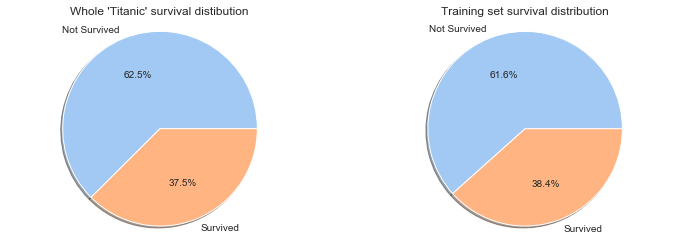

In [280]:
sns.set_style('darkgrid')
sns.set_palette('pastel')

x = [819/1311, 492/1311]
f, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].pie(x,labels = [ 'Not Survived','Survived'], shadow = True,autopct='%1.1f%%')
ax[0].set_title('Whole \'Titanic\' survival distibution')
ax[0].axis('equal')
ax[1].pie(train_df['Survived'].value_counts()/891, labels = ['Not Survived', 'Survived'],shadow = True, autopct='%1.1f%%')
ax[1].set_title('Training set survival distribution')
ax[1].axis('equal')
plt.show()

It looks like training set and the whole 'Titanic' data has similiar distibution.

In [281]:
train_df.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,29.737705,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.108684,0.473684,0.464912,48.395408


##### Sex

In [282]:
train_df.groupby(['Sex']).mean()[['Survived','Age','SibSp','Parch','Fare']]

,Survived,Age,SibSp,Parch,Fare
Sex,,,,,
female,0.742038,27.261146,0.694268,0.649682,44.479818
male,0.188908,30.119879,0.429809,0.235702,25.523893


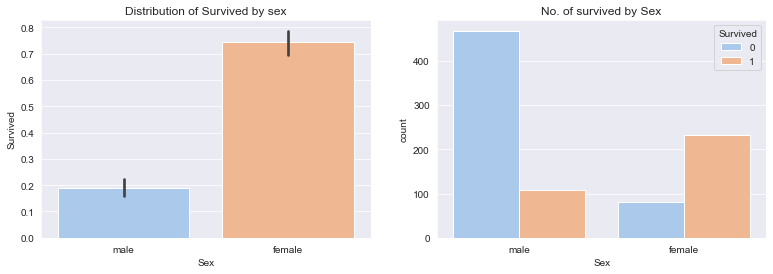

In [283]:
f,ax = plt.subplots(1,2, figsize= (13,4))
sns.barplot(x='Sex', y= 'Survived', data = train_df, ax = ax[0])
ax[0].set_title('Distribution of Survived by sex')
sns.countplot(x = 'Sex',hue = 'Survived', data = train_df, ax = ax[1])
ax[1].set_title('No. of survived by Sex')
plt.show()

As we could guess, females have significantly higer survival rate.

In [284]:
train_df.groupby('Pclass').mean()['Survived']*100

Pclass
1    62.962963
2    47.282609
3    24.236253
Name: Survived, dtype: float64

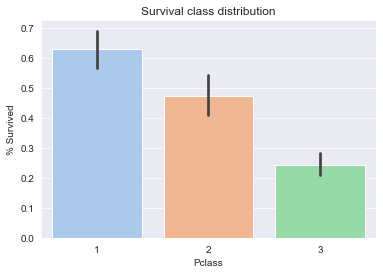

In [285]:
f, ax = plt.subplots()
sns.barplot(x='Pclass', y= 'Survived', data = train_df)
ax.set_title('Survival class distribution')
ax.set_ylabel('% Survived')
plt.show()

Another not surprising conclusion is the higher class, the higher survival rate.

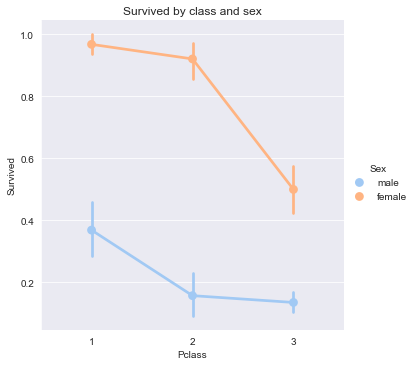

In [286]:
ax = sns.factorplot('Pclass', 'Survived', hue = 'Sex', data = train_df)
plt.title('Survived by class and sex')
plt.show()

There is higher survival rate of 3rd class female, than 1st class male.

In [287]:
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

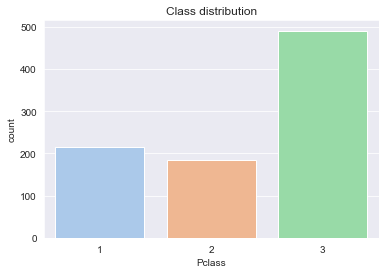

In [288]:
f, ax = plt.subplots()
sns.countplot(x='Pclass', data = train_df)
ax.set_title('Class distribution')

plt.show()

Third class was by far the most crowded.

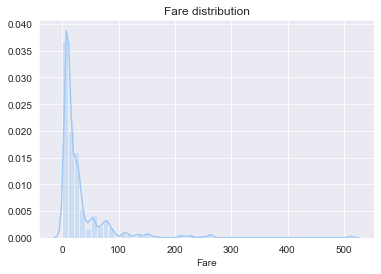

In [289]:
sns.distplot(train_df['Fare'],kde = True)
plt.title('Fare distribution')
plt.xlabel('Fare')
plt.show()

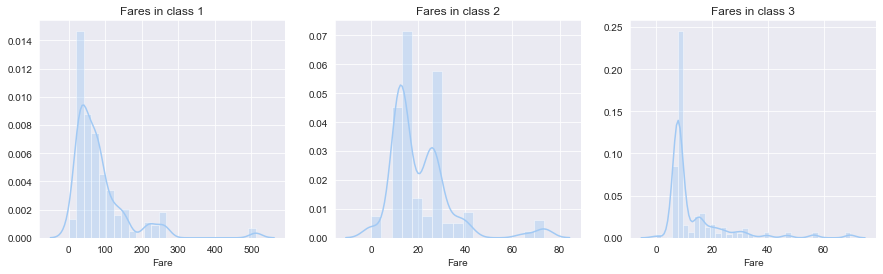

In [290]:
f, ax = plt.subplots(1,3, figsize = (15,4))
sns.distplot(train_df[train_df['Pclass'] == 1].Fare, ax = ax[0])
ax[0].set_title('Fares in class 1')
sns.distplot(train_df[train_df['Pclass'] == 2].Fare, ax = ax[1])
ax[1].set_title('Fares in class 2')
sns.distplot(train_df[train_df['Pclass'] == 3].Fare, ax = ax[2])
ax[2].set_title('Fares in class 3')
plt.show()

1. Distribution of fare in class 1 shows us that most people paid between 0 and 100 dollars, but there are people who paid about 500 dollars
2. In class 2 most people paid between 0 and 40 dollars. However a few people paid nearly 80 dollars.
3. In class 3, passengers usually pay around 0 to 20 dollars, but for some reason someone paid over 60 dollars for 3rd class ticket


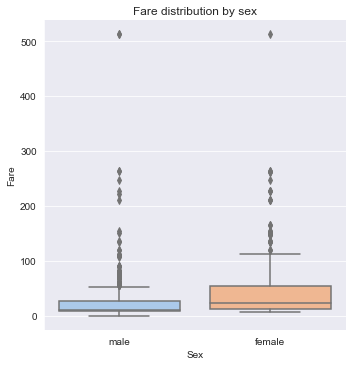

In [291]:
sns.catplot(x = 'Sex', y='Fare', data = train_df, kind = 'box')
plt.title('Fare distribution by sex')
plt.show()

More women were in first class, so the average fare is also higher

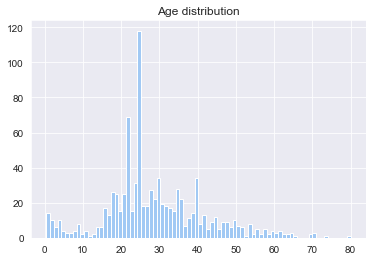

In [292]:
plt.hist(train_df['Age'], bins = 80)
plt.title('Age distribution')
plt.show()

Text(0.5, 1.0, 'Age distribution')

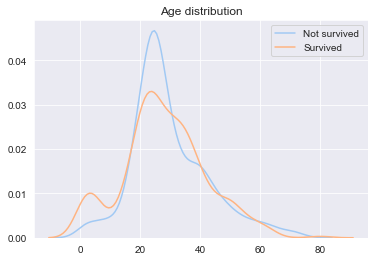

In [293]:
ax = sns.kdeplot(train_df.loc[(train_df['Survived'] == 0) , 'Age'], label = 'Not survived')
ax = sns.kdeplot(train_df.loc[(train_df['Survived'] == 1), 'Age'], label = 'Survived')
plt.title('Age distribution')

We can't see anything unexpeted in the plot, kids had the priority to survive.

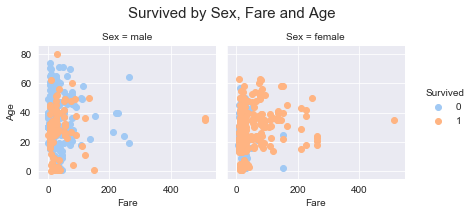

In [294]:
ax = sns.FacetGrid(train_df, col = 'Sex', hue = 'Survived', margin_titles= True)
ax.map(plt.scatter, 'Fare', 'Age').add_legend()
ax.fig.suptitle('Survived by Sex, Fare and Age', size = 15)
plt.subplots_adjust(top = 0.80)

plt.show()

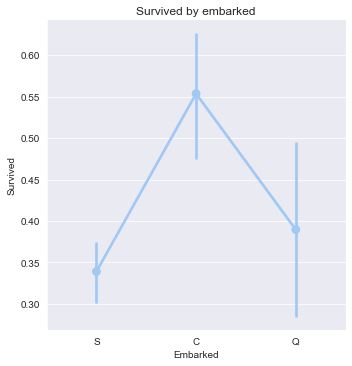

In [295]:
sns.factorplot('Embarked','Survived' , data = train_df)
plt.title('Survived by embarked')
plt.show()

The place passenger starts has interesting impact on survival rate.

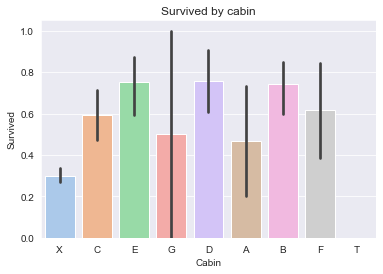

In [296]:
f, ax  = plt.subplots()
sns.barplot(x = 'Cabin', y = 'Survived' , data = train_df)
ax.set_title('Survived by cabin')
plt.show()

In [297]:
pd.DataFrame(train_df.corr()['Survived'].sort_values(ascending = False))

,Survived
Survived,1.000000
Fare,0.257307
Parch,0.081629
PassengerId,-0.005007
SibSp,-0.035322
Age,-0.059579
Pclass,-0.338481


In [298]:
pd.DataFrame(abs(train_df.corr()['Survived']).sort_values(ascending = False))

,Survived
Survived,1.000000
Pclass,0.338481
Fare,0.257307
Parch,0.081629
Age,0.059579
SibSp,0.035322
PassengerId,0.005007


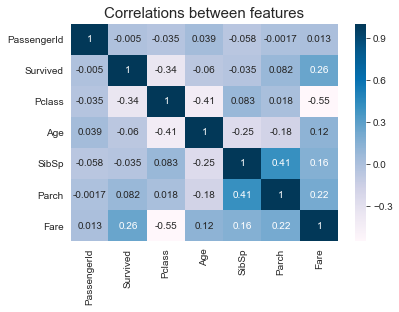

In [299]:
f, ax = plt.subplots()
sns.heatmap(train_df.corr(), annot= True, cmap = 'PuBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlations between features', fontsize = 15)
plt.show()

As we can see from the heatmap above, there is strong correlation between Pclass and survival. Also, Pclass and Fare are highly correlated, so passengers who pay more money were more likely to survive.

### Feature engineering

In [300]:
all_df = pd.concat([train_df, test_df])

#### Family size

In [301]:
all_df['Family_size'] = all_df['SibSp'] + all_df['Parch'] + 1

#### IsAlone

In [302]:
all_df['IsAlone'] = [1 if i == 1 else 0 for i in all_df['Family_size']]

##### Age

In [303]:
all_df['Age'] = pd.qcut(train_df['Age'], 10)


In [304]:
all_df['Age_cat'] = pd.factorize(all_df['Age'])[0]
all_df = pd.get_dummies(all_df, prefix = 'Age', columns = ['Age_cat'])
all_df.drop('Age', inplace = True, axis = 1)

#### Pclass

In [305]:
all_df = pd.get_dummies(all_df,prefix='Pc',columns = ['Pclass'])

#### Fare

In [306]:
all_df['Fare'] = pd.qcut(all_df['Fare'], 12)
all_df['Fare_cat'] = pd.factorize(all_df['Fare'])[0]
all_df = pd.get_dummies(all_df, prefix = 'F', columns = ['Fare_cat'])

In [307]:
all_df.drop('Fare', inplace = True, axis = 1)

#### Sex

In [308]:
all_df['Sex'] = all_df['Sex'].map({'male':1, 'female':0})

all_df = pd.get_dummies(all_df , prefix = 'S' , columns = ['Sex'])

#### Cabin

In [309]:
all_df = pd.get_dummies(all_df, prefix= 'C', columns=['Cabin'])

#### Embarked

In [310]:
all_df = pd.get_dummies(all_df, prefix='E', columns=['Embarked'])

 ##### Name

In my opinion the title might have strong impact on survive chance

In [311]:
all_df['Title']= all_df['Name'].str.split(', ', expand= True)[1].str.split('. ', expand= True)[0]

In [312]:
all_df.drop('Name', axis = 1, inplace= True) # I don't think we can get more from the 'Name' column

In [313]:
all_df['Title'] = all_df['Title'].replace(['Dr','Rev','Col','Major','Mlle','Ms','Lady','th','Mme','Sir','Capt','Jonkheer','Don', 'Dona'], 'Rare')

In [314]:
all_df['Title'].value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Rare       34
Name: Title, dtype: int64

In [315]:
all_df['Title'] = all_df['Title'].map({'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5})

#### Ticket

Prefixes may tell us something more about the cabin or class.

In [316]:
PrefixesTrain = []
PrefixesTest = []
def prefs(series, prefList): #A method to get prefixes from the ticket number
    for i in series:
        if not i.isdigit():
            prefList.append(i.replace('.','').replace('/','').strip().split()[0])
        else:
            prefList.append('X')

In [317]:
prefs(all_df['Ticket'], PrefixesTrain)

In [318]:
def uniquevalues(list1): #quick method to check unique values of the list
    x = np.array(list1)
    print(np.unique(x))
    
uniquevalues(PrefixesTrain), uniquevalues(PrefixesTest)

['A' 'A4' 'A5' 'AQ3' 'AQ4' 'AS' 'C' 'CA' 'CASOTON' 'FC' 'FCC' 'Fa' 'LINE'
 'LP' 'PC' 'PP' 'PPP' 'SC' 'SCA3' 'SCA4' 'SCAH' 'SCOW' 'SCPARIS' 'SCParis'
 'SOC' 'SOP' 'SOPP' 'SOTONO2' 'SOTONOQ' 'SP' 'STONO' 'STONO2' 'STONOQ'
 'SWPP' 'WC' 'WEP' 'X']
[]


(None, None)

Rest of the ticket seems useless, so we will replace the original "Ticket" column with the prefixes we got.

In [319]:
all_df['Ticket'] = PrefixesTrain

In [320]:
all_df = pd.get_dummies(all_df, prefix = 'T', columns = ['Ticket'])

In [321]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 84 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   SibSp        1309 non-null   int64  
 3   Parch        1309 non-null   int64  
 4   label        1309 non-null   object 
 5   Family_size  1309 non-null   int64  
 6   IsAlone      1309 non-null   int64  
 7   Age_0        1309 non-null   uint8  
 8   Age_1        1309 non-null   uint8  
 9   Age_2        1309 non-null   uint8  
 10  Age_3        1309 non-null   uint8  
 11  Age_4        1309 non-null   uint8  
 12  Age_5        1309 non-null   uint8  
 13  Age_6        1309 non-null   uint8  
 14  Age_7        1309 non-null   uint8  
 15  Age_8        1309 non-null   uint8  
 16  Age_9        1309 non-null   uint8  
 17  Pc_1         1309 non-null   uint8  
 18  Pc_2         1309 non-null   uint8  
 19  Pc_3   

In [322]:
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,label
548,549,0,3,"Goldsmith, Mr. Frank John",male,33.0,1,1,363291,20.5250,X,S,train
659,660,0,1,"Newell, Mr. Arthur Webster",male,58.0,0,2,35273,113.2750,D,C,train
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,21.5,8,2,CA. 2343,69.5500,X,S,train
288,289,1,2,"Hosono, Mr. Masabumi",male,42.0,0,0,237798,13.0000,X,S,train
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,X,C,train


In [323]:
all_df.sample(5)

,PassengerId,Survived,SibSp,Parch,label,Family_size,IsAlone,Age_0,Age_1,Age_2,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
332,1224,NaN,0,0,test,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
264,1156,NaN,0,0,test,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
201,202,0.0,8,2,train,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72,964,NaN,0,0,test,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
361,1253,NaN,1,1,test,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [324]:
train_df = all_df[all_df['label'] == 'train']
test_df = all_df[all_df['label'] == 'test']

In [325]:
train_df.drop(['label', 'PassengerId'], axis = 1 , inplace = True)
test_df.drop(['label','Survived'], axis = 1, inplace = True)

In [326]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 82 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    float64
 1   SibSp        891 non-null    int64  
 2   Parch        891 non-null    int64  
 3   Family_size  891 non-null    int64  
 4   IsAlone      891 non-null    int64  
 5   Age_0        891 non-null    uint8  
 6   Age_1        891 non-null    uint8  
 7   Age_2        891 non-null    uint8  
 8   Age_3        891 non-null    uint8  
 9   Age_4        891 non-null    uint8  
 10  Age_5        891 non-null    uint8  
 11  Age_6        891 non-null    uint8  
 12  Age_7        891 non-null    uint8  
 13  Age_8        891 non-null    uint8  
 14  Age_9        891 non-null    uint8  
 15  Pc_1         891 non-null    uint8  
 16  Pc_2         891 non-null    uint8  
 17  Pc_3         891 non-null    uint8  
 18  F_0          891 non-null    uint8  
 19  F_1     

In [327]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 82 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   SibSp        418 non-null    int64
 2   Parch        418 non-null    int64
 3   Family_size  418 non-null    int64
 4   IsAlone      418 non-null    int64
 5   Age_0        418 non-null    uint8
 6   Age_1        418 non-null    uint8
 7   Age_2        418 non-null    uint8
 8   Age_3        418 non-null    uint8
 9   Age_4        418 non-null    uint8
 10  Age_5        418 non-null    uint8
 11  Age_6        418 non-null    uint8
 12  Age_7        418 non-null    uint8
 13  Age_8        418 non-null    uint8
 14  Age_9        418 non-null    uint8
 15  Pc_1         418 non-null    uint8
 16  Pc_2         418 non-null    uint8
 17  Pc_3         418 non-null    uint8
 18  F_0          418 non-null    uint8
 19  F_1          418 non-null    uint8
 20  F_2       

## Modeling

In [328]:
y = train_df['Survived'].values
X = train_df.drop('Survived', axis = 1).values

In [329]:
X.shape

(891, 81)

In [330]:
y.shape

(891,)

In [331]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 20, random_state = 42)

##### Decision Tree

In [332]:
DT = DecisionTreeClassifier()

In [333]:
DTcv = cross_val_score(DT, X,y, cv = 5)

In [334]:
DT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [335]:
print('Decision Tree Classifier score: {:.2%} '.format(DT.score(X_test, y_test)))

Decision Tree Classifier score: 85.00% 


##### Random Forest

In [336]:
RF = RandomForestClassifier()

In [337]:
cross_val_score(RF,X, y)

array([0.7877095 , 0.79213483, 0.83146067, 0.79775281, 0.83707865])

In [338]:
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [339]:
print('Random Forest Classifier score: {:.2%}'.format(RF.score(X_test,y_test)))

Random Forest Classifier score: 85.00%


##### Logistic Regression

In [340]:
LR = LogisticRegression()

In [341]:
cross_val_score(LR,X, y)

array([0.79329609, 0.80898876, 0.81460674, 0.80898876, 0.83146067])

In [342]:
LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [343]:
print('Logistic Regression score: {:.2%}'.format(LR.score(X_test,y_test)))

Logistic Regression score: 85.00%


##### Gradient Boosting

In [344]:
GB = GradientBoostingClassifier()

In [345]:
cross_val_score(GB,X, y)

array([0.83240223, 0.81460674, 0.82022472, 0.80337079, 0.86516854])

In [346]:
GB.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [347]:
print('Gradient Boosting Classifier score: {:.2%}'.format(GB.score(X_test,y_test)))

Gradient Boosting Classifier score: 95.00%


##### K Nearest Neighbors

In [348]:
KNN = KNeighborsClassifier()

In [349]:
cross_val_score(KNN, X, y)

array([0.75977654, 0.79775281, 0.81460674, 0.80898876, 0.82022472])

In [350]:
KNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [351]:
print('K-Nearest Neigbors Classifier score: {:.2%}'.format(KNN.score(X_test,y_test)))

K-Nearest Neigbors Classifier score: 85.00%


##### SVC

In [352]:
SVC = SVC(probability = True)

In [353]:
cross_val_score(SVC,X, y)

array([0.84916201, 0.81460674, 0.8258427 , 0.80898876, 0.85393258])

In [354]:
SVC.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [355]:
print('SVC score: {:.2%}'.format(SVC.score(X_test,y_test)))

SVC score: 95.00%


### Hyper parameters tuning

##### Ada boosting

In [356]:
AdaDT = AdaBoostClassifier(DT, random_state = 5)

In [357]:
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

In [358]:
AdaDTcv = GridSearchCV(AdaDT, param_grid=ada_param_grid, cv = 5, n_jobs= 2)

In [359]:
AdaDTcv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

In [360]:
AdaDTbe = AdaDTcv.best_estimator_

In [361]:
print('Tuned Ada Boosted Decision Tree Classifer score: {:.2%}'.format(AdaDTbe.score(X_test, y_test)))

Tuned Ada Boosted Decision Tree Classifer score: 85.00%


###### Random Forest

In [362]:
kfold = StratifiedKFold(n_splits=5)

In [363]:
rf_param_grid = {"max_depth": [2,4,6,8, None] ,
              "max_features": ['auto', 'sqrt', 'log2'],#[1, 3, 10]
              "min_samples_split": [1,2, 4, 6],
              "min_samples_leaf": [1, 2, 4, 6],
              "bootstrap": [False, True],#usuniecie True
              "n_estimators" :[100,300,500],
              "criterion": ["gini", "entropy"]}#usuniecie entropy

In [364]:
RFcv = GridSearchCV(RF, param_grid = rf_param_grid, cv = kfold, n_jobs = 2)

In [365]:
RFcv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,...
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='deprecated', n_jobs=2,
         

In [366]:
RFbe = RFcv.best_estimator_

In [367]:
print('Tuned Random Forest Classifer score: {:.2%}'.format(RFbe.score(X_test, y_test)))

Tuned Random Forest Classifer score: 90.00%


In [368]:
importances = pd.DataFrame({'feature':train_df.drop(['Survived'], axis = 1).columns,'importance':np.round(RFbe.feature_importances_,3)})
importances = importances.sort_values(by = 'importance', ascending = False).set_index('feature')

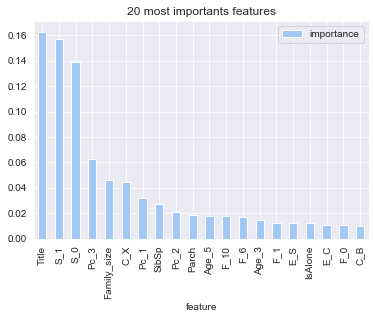

In [369]:
importances.head(20).plot.bar()
plt.title('20 most importants features')
plt.show()

###### Gradient Boosting

In [370]:
GB_grid_params = {"loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

In [371]:
GBcv = GridSearchCV(GB, param_grid=GB_grid_params, cv = 5, n_jobs = 2)

In [372]:
#GBcv.fit(X_train, y_train)

In [373]:
#GBbe = GBcv.best_estimator_

In [374]:
#print('Tuned Gradient Boosting Classifer score: {:.2%}'.format(GBbe.score(X_test, y_test)))

##### SVC

In [375]:
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

SVCcv = GridSearchCV(SVC,param_grid = svc_param_grid, cv=5, n_jobs= 2)

In [376]:
#SVCcv.fit(X_train, y_train)

In [377]:
#SVCbe = SVCcv.best_estimator_ 

In [378]:
#print('Tuned SVC score: {:.2%}'.format(SVCbe.score(X_test, y_test)))

#### Voting Classifier

In [379]:
#votingC = VotingClassifier(estimators=[('rfc', RFbe),
#('svc', SVCbe), ('adac',AdaDTbe),('gbc',GB)], voting='hard', n_jobs=2)

In [380]:
#votingC.fit(X_train, y_train)

### Final submission

##### At the end i decided to choose Random Forest, as i had the best score with this classifier

In [381]:
passenderid = test_df['PassengerId']
predict = RFbe.predict(test_df.drop(['PassengerId'], axis = 1))
solution = pd.DataFrame({'PassengerId' : passenderid, 'Survived' : predict.astype('int64')})
solution.to_csv('subimssionRandomForest.csv', index = False)

###### The goal of this project was to score ~0.80 in kaggle competition. On the current hyperparameters its around 0.788-0.80. Best i could score was 0.80143.